In [39]:
import pandas as pd
import numpy as np
import string
import re
import regex
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [40]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [98]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.utils.vis_utils import plot_model

In [42]:
train_df=pd.read_excel('bert_sample.xlsx')
train_df

,ITEM_NAME,CATEGORY_ID
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY
1,for pusher whskey,CAPITAL ASSEMBLY
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY
...,...,...
9995,Export Freight charges By Road,LOGISTICS SERVICE
9996,EXPORT PACKING,LOGISTICS SERVICE
9997,Express Delivery Charges,LOGISTICS SERVICE
9998,Express Delivery Charges for PMF to CHMF Despa...,LOGISTICS SERVICE


In [43]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [44]:
X = []
sentences = list(train_df['ITEM_NAME'])
for sen in sentences:
    X.append(preprocess_text(sen))
y=le.fit_transform(train_df['CATEGORY_ID'])
y

array([0, 0, 0, ..., 3, 3, 3])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [46]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Glove 

### !wget http://nlp.stanford.edu/data/glove.6B.zip

In [47]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [51]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(256,return_sequences='true')(embedding_layer)

dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          708600    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 256)          365568    
_________________________________________________________________
dense_6 (Dense)              (None, 100, 1)            257       
Total params: 1,074,425
Trainable params: 365,825
Non-trainable params: 708,600
_________________________________________________________________


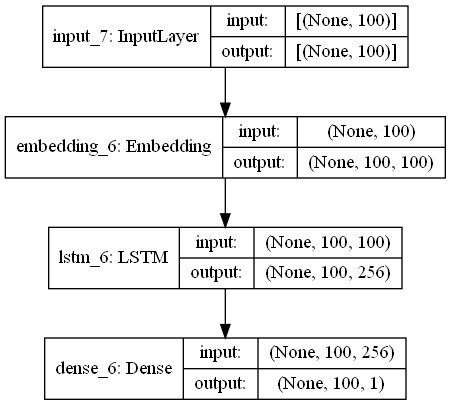

In [101]:
plot_model(model, to_file='LSTM_model_plot.png', show_shapes=True, show_layer_names=True)


In [52]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 35s 299ms/step - loss: -4.9526 - acc: 0.1968 - val_loss: -7.3729 - val_acc: 0.2006
Epoch 2/50
100/100 [==============================] - 28s 279ms/step - loss: -7.4577 - acc: 0.2058 - val_loss: -7.4139 - val_acc: 0.2006
Epoch 3/50
100/100 [==============================] - 28s 284ms/step - loss: -7.6682 - acc: 0.2006 - val_loss: -7.4329 - val_acc: 0.2006
Epoch 4/50
100/100 [==============================] - 28s 276ms/step - loss: -7.5648 - acc: 0.1992 - val_loss: -7.4462 - val_acc: 0.2006
Epoch 5/50
100/100 [==============================] - 28s 275ms/step - loss: -7.7006 - acc: 0.1984 - val_loss: -7.4566 - val_acc: 0.2006
Epoch 6/50
100/100 [==============================] - 28s 284ms/step - loss: -8.0294 - acc: 0.2015 - val_loss: -7.4649 - val_acc: 0.2006
Epoch 7/50
100/100 [==============================] - 27s 275ms/step - loss: -7.8960 - acc: 0.1989 - val_loss: -7.4719 - val_acc: 0.2006
Epoch 8/50
100/100 [=====================

In [53]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [58]:
model1 = Sequential()
model1.add(Input(shape=(maxlen,)))
model1.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
model1.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(256, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.add(Activation('sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          708600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 256)           295936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 50, 1)             257       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 1)            

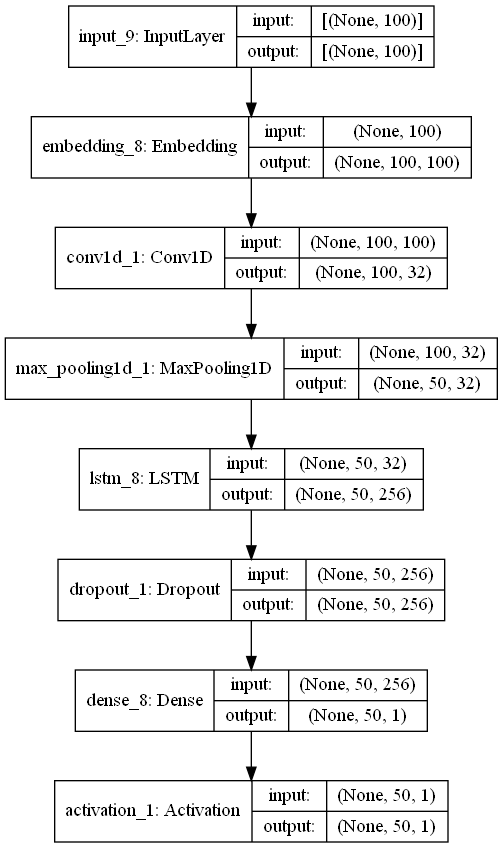

In [100]:
plot_model(model1, to_file='CNN_lstm_model1_plot.png', show_shapes=True, show_layer_names=True)

In [61]:
batch_size=64
model1.fit(X_train, y_train, batch_size=batch_size, epochs=500, validation_split=0.2)


Epoch 1/500
100/100 [==============================] - 16s 151ms/step - loss: -9.3283 - acc: 0.3041 - val_loss: -8.8649 - val_acc: 0.2923
Epoch 2/500
100/100 [==============================] - 15s 153ms/step - loss: -9.3544 - acc: 0.3064 - val_loss: -8.8025 - val_acc: 0.2910
Epoch 3/500
100/100 [==============================] - 15s 149ms/step - loss: -9.3772 - acc: 0.3055 - val_loss: -8.7410 - val_acc: 0.2905
Epoch 4/500
100/100 [==============================] - 15s 154ms/step - loss: -9.4036 - acc: 0.3073 - val_loss: -8.8466 - val_acc: 0.2931
Epoch 5/500
100/100 [==============================] - 15s 148ms/step - loss: -9.4075 - acc: 0.3086 - val_loss: -8.8419 - val_acc: 0.2916
Epoch 6/500
100/100 [==============================] - 16s 160ms/step - loss: -9.4319 - acc: 0.3105 - val_loss: -8.8441 - val_acc: 0.2928
Epoch 7/500
100/100 [==============================] - 15s 150ms/step - loss: -9.4442 - acc: 0.3114 - val_loss: -8.8444 - val_acc: 0.2936
Epoch 8/500
100/100 [=============

100/100 [==============================] - 16s 158ms/step - loss: -9.5871 - acc: 0.3212 - val_loss: -8.8997 - val_acc: 0.2980
Epoch 61/500
100/100 [==============================] - 15s 151ms/step - loss: -9.5977 - acc: 0.3219 - val_loss: -8.8412 - val_acc: 0.3002
Epoch 62/500
100/100 [==============================] - 15s 153ms/step - loss: -9.5970 - acc: 0.3222 - val_loss: -8.8745 - val_acc: 0.2996
Epoch 63/500
100/100 [==============================] - 15s 153ms/step - loss: -9.6067 - acc: 0.3226 - val_loss: -8.8255 - val_acc: 0.2990
Epoch 64/500
100/100 [==============================] - 16s 160ms/step - loss: -9.6063 - acc: 0.3226 - val_loss: -8.8027 - val_acc: 0.2991
Epoch 65/500
100/100 [==============================] - 15s 150ms/step - loss: -9.5692 - acc: 0.3201 - val_loss: -8.7902 - val_acc: 0.2963
Epoch 66/500
100/100 [==============================] - 15s 151ms/step - loss: -9.6065 - acc: 0.3227 - val_loss: -8.9166 - val_acc: 0.2985
Epoch 67/500
100/100 [==================

Epoch 119/500
100/100 [==============================] - 14s 145ms/step - loss: -9.6761 - acc: 0.3273 - val_loss: -8.7870 - val_acc: 0.3008
Epoch 120/500
100/100 [==============================] - 15s 146ms/step - loss: -9.6762 - acc: 0.3273 - val_loss: -8.7802 - val_acc: 0.3005
Epoch 121/500
100/100 [==============================] - 15s 146ms/step - loss: -9.6764 - acc: 0.3272 - val_loss: -8.7507 - val_acc: 0.3020
Epoch 122/500
100/100 [==============================] - 17s 167ms/step - loss: -9.6788 - acc: 0.3275 - val_loss: -8.7347 - val_acc: 0.3018
Epoch 123/500
100/100 [==============================] - 16s 160ms/step - loss: -9.6788 - acc: 0.3274 - val_loss: -8.7173 - val_acc: 0.3019
Epoch 124/500
100/100 [==============================] - 16s 160ms/step - loss: -9.6789 - acc: 0.3275 - val_loss: -8.7883 - val_acc: 0.3011
Epoch 125/500
100/100 [==============================] - 15s 151ms/step - loss: -9.6788 - acc: 0.3275 - val_loss: -8.7502 - val_acc: 0.3020
Epoch 126/500
100/10

100/100 [==============================] - 19s 193ms/step - loss: -9.7630 - acc: 0.3330 - val_loss: -8.7709 - val_acc: 0.3017
Epoch 236/500
100/100 [==============================] - 22s 216ms/step - loss: -9.7631 - acc: 0.3329 - val_loss: -8.7802 - val_acc: 0.3017
Epoch 237/500
100/100 [==============================] - 22s 220ms/step - loss: -9.7633 - acc: 0.3330 - val_loss: -8.7735 - val_acc: 0.3017
Epoch 238/500
100/100 [==============================] - 22s 217ms/step - loss: -9.7633 - acc: 0.3330 - val_loss: -8.7830 - val_acc: 0.3016
Epoch 239/500
100/100 [==============================] - 22s 217ms/step - loss: -9.7634 - acc: 0.3330 - val_loss: -8.7792 - val_acc: 0.3016
Epoch 240/500
100/100 [==============================] - 22s 219ms/step - loss: -9.7634 - acc: 0.3330 - val_loss: -8.7851 - val_acc: 0.3017
Epoch 241/500
100/100 [==============================] - 21s 215ms/step - loss: -9.7635 - acc: 0.3330 - val_loss: -8.7745 - val_acc: 0.3017
Epoch 242/500
100/100 [===========

100/100 [==============================] - 21s 208ms/step - loss: -9.8071 - acc: 0.3360 - val_loss: -8.5884 - val_acc: 0.3018
Epoch 352/500
100/100 [==============================] - 21s 210ms/step - loss: -9.8071 - acc: 0.3359 - val_loss: -8.5492 - val_acc: 0.3022
Epoch 353/500
100/100 [==============================] - 22s 223ms/step - loss: -9.8071 - acc: 0.3359 - val_loss: -8.5261 - val_acc: 0.3023
Epoch 354/500
100/100 [==============================] - 21s 212ms/step - loss: -9.8071 - acc: 0.3358 - val_loss: -8.5231 - val_acc: 0.3023
Epoch 355/500
100/100 [==============================] - 21s 211ms/step - loss: -9.8071 - acc: 0.3359 - val_loss: -8.5515 - val_acc: 0.3022
Epoch 356/500
100/100 [==============================] - 23s 232ms/step - loss: -9.8070 - acc: 0.3359 - val_loss: -8.5346 - val_acc: 0.3023
Epoch 357/500
100/100 [==============================] - 24s 245ms/step - loss: -9.8072 - acc: 0.3359 - val_loss: -8.5099 - val_acc: 0.3023
Epoch 358/500
100/100 [===========

100/100 [==============================] - 32s 322ms/step - loss: -9.8538 - acc: 0.3398 - val_loss: -8.8064 - val_acc: 0.3073
Epoch 468/500
100/100 [==============================] - 32s 322ms/step - loss: -9.8679 - acc: 0.3395 - val_loss: -8.6341 - val_acc: 0.3115
Epoch 469/500
100/100 [==============================] - 32s 320ms/step - loss: -9.8699 - acc: 0.3400 - val_loss: -8.9120 - val_acc: 0.3052
Epoch 470/500
100/100 [==============================] - 32s 322ms/step - loss: -9.8714 - acc: 0.3397 - val_loss: -8.8574 - val_acc: 0.3072
Epoch 471/500
100/100 [==============================] - 32s 319ms/step - loss: -9.8770 - acc: 0.3404 - val_loss: -8.8579 - val_acc: 0.3071
Epoch 472/500
100/100 [==============================] - 32s 322ms/step - loss: -9.8773 - acc: 0.3403 - val_loss: -8.8526 - val_acc: 0.3071
Epoch 473/500
100/100 [==============================] - 32s 321ms/step - loss: -9.8348 - acc: 0.3397 - val_loss: -8.8833 - val_acc: 0.3003
Epoch 474/500
100/100 [===========

In [96]:
accr = model1.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
# 

63/63 [==============================] - 6s 94ms/step - loss: -8.5527 - acc: 0.3123
Test set
  Loss: -8.553
  Accuracy: 0.312


In [75]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          708600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 256)           295936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 50, 1)             257       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 1)            

In [86]:
import datetime
log_dir = ".LSTM/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history=model1.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_split=0.2,callbacks=[tensorboard_callback])



Epoch 1/5
100/100 [==============================] - 31s 306ms/step - loss: -9.8657 - acc: 0.3406 - val_loss: -8.7779 - val_acc: 0.3049
Epoch 2/5
100/100 [==============================] - 29s 288ms/step - loss: -9.9146 - acc: 0.3428 - val_loss: -8.9358 - val_acc: 0.3072
Epoch 3/5
100/100 [==============================] - 29s 292ms/step - loss: -9.9656 - acc: 0.3453 - val_loss: -8.9236 - val_acc: 0.3100
Epoch 4/5
100/100 [==============================] - 30s 299ms/step - loss: -9.9632 - acc: 0.3453 - val_loss: -8.9363 - val_acc: 0.3127
Epoch 5/5
100/100 [==============================] - 29s 287ms/step - loss: -9.9664 - acc: 0.3458 - val_loss: -8.9013 - val_acc: 0.3166


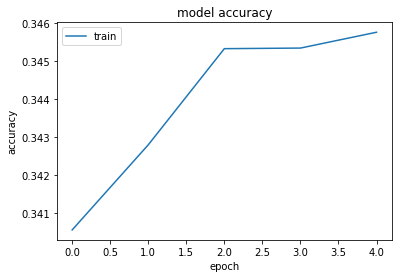

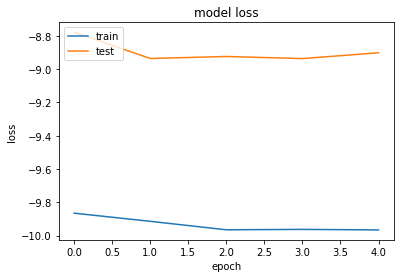

In [95]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()